In [1]:
import os
import cv2
import math
import kornia
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch

# Front view
Some good exmaples: 107, 110, 122, 124 (all sample_0)

In [2]:
corner_names = [
    'fl_x', 'fr_x', 'bl_x', 'br_x', 'fl_y', 'fr_y','bl_y', 'br_y']
colors = ['c', 'r', 'b', 'g']

def draw_box(ax, corners, color):
    point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
    ax.plot(point_squence.T[0], point_squence.T[1], color=color)
    
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return torch.tensor([qx, qy])

def get_images(data_root, scene_id, sample_id, view, points_src, points_dst):
    path = os.path.join(data_root, 'scene_%d' % scene_id, 'sample_%d' % sample_id)

    # Get target
    anno = pd.read_csv('data/annotation.csv')
    data_entries = anno[(anno['scene']==scene_id)\
        & (anno['sample']==sample_id)]
    corners = data_entries[corner_names].to_numpy()

    corners = torch.tensor(
        data_entries[corner_names].to_numpy(), dtype=torch.float).view(-1, 2, 4)
    corners[:, 0, :] = corners[:, 0, :] * 10 + 400
    corners[:, 1, :] = -corners[:, 1, :] * 10 + 400

    # Rotate
    for i in range(len(corners)):
        for j in range(4):
            corners[i, :, j] = rotate((400, 400), corners[i, :, j], -math.pi / 2)

    # Read images
    img = cv2.imread(os.path.join(path, '{}.jpeg'.format(view)))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    src_img = kornia.image_to_tensor(img, keepdim=False)

    dst_h, dst_w = 800, 800

    # Compute perspective transform
    M = kornia.get_perspective_transform(points_src, points_dst)

    # Image to BEV transformation
    dst_img = kornia.warp_perspective(
        src_img.float(), M, dsize=(dst_h, dst_w), flags='bilinear', border_mode='zeros')

    # dst_img = kornia.geometry.transform.rotate(dst_img, torch.tensor([-70]))


    # dst_img[:, :, 450:, :] = 0
    dst_img = kornia.tensor_to_image(dst_img.byte())

    # Visualization
    fig, axs = plt.subplots(1, 2, figsize=(16, 10))
    axs = axs.ravel()

    axs[0].set_title('image source')
    axs[0].imshow(img)

    axs[1].set_title('image destination')
    axs[1].imshow(dst_img)
    axs[1].plot(400, 400, 'x', color='red')
    for i, bb in enumerate(corners):
        draw_box(axs[1], bb, color='r')

    for i in range(points_src.size(1)):
        axs[0].scatter(points_src[0, i, 0], points_src[0, i, 1], color=colors[i])
        axs[1].scatter(points_dst[0, i, 0], points_dst[0, i, 1], color=colors[i])

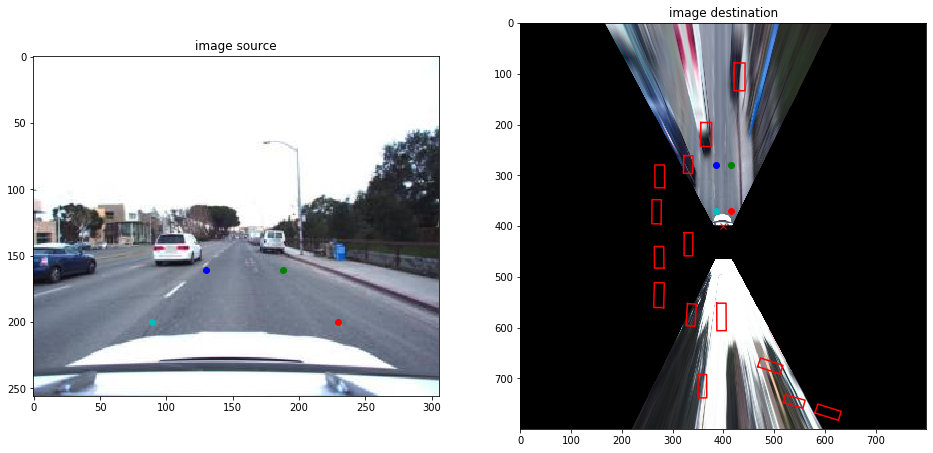

In [3]:
data_root = 'data'

scene_id = 124
sample_id = 0
points_src = torch.tensor([[
    [89., 200.], [229., 200.], [130., 161.], [188., 161.],
]])
x_min = 385
x_max = 415
y_min = 280.
y_max = 370.
points_dst = torch.tensor([[
    [x_min, y_max], [x_max, y_max], [x_min, y_min], [x_max, y_min],
]])
get_images(data_root, scene_id, sample_id, 'CAM_FRONT', points_src, points_dst)

# Front right view
Some good examples: 111, 112, 124, 128 (all sample_0)

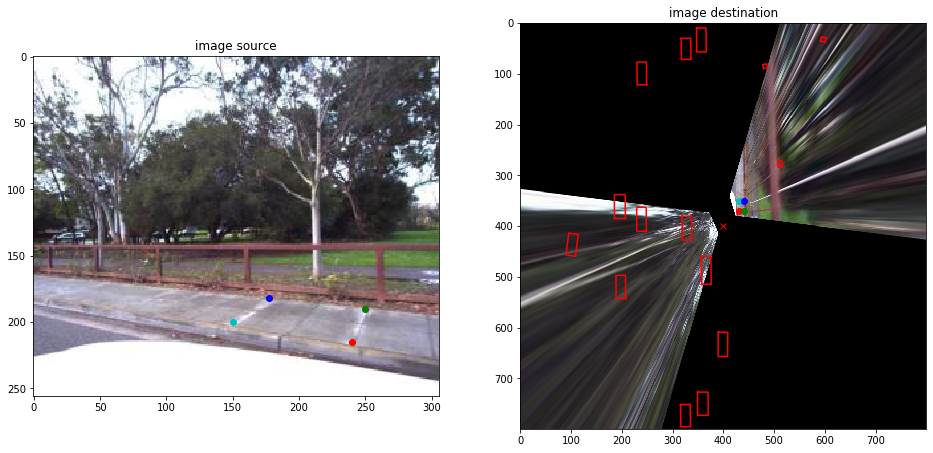

In [4]:
scene_id = 111
sample_id = 0
points_src = torch.tensor([[
    [150., 200.], [240., 215.], [177., 182.], [250., 190.],
]])
x_min = 430.
x_max = 440.
y_min = 350.
y_max = 370.
points_dst = torch.tensor([[
    [x_min, y_min], [x_min, y_max], [x_max, y_min], [x_max, y_max],
]])
get_images(data_root, scene_id, sample_id, 'CAM_FRONT_RIGHT', points_src, points_dst)